Daiana Alonso - Utilizar MapReduce para el grupo de datos C 

Librerias necesarias para la ejecución de esta notebook

In [1]:
from functools import reduce
import xml.etree.ElementTree as ET
from lib.chunckify import chunckify
from collections import Counter
import math
import re
import os
import pandas as pd
import seaborn as sns

Carga del archivo que contiene los datos sobre posts en la plataforma Stack Overflow

In [2]:
# Busqueda del path donde se está ejecutando el archivo
path_actual = os.path.abspath('')

# Path de la carpeta output
path_output = os.path.join(path_actual, "output")

# Path del archivo posts.xml
path_posts = os.path.join(path_actual, "dataset/Stack Overflow 11-2010/112010 Meta Stack Overflow/posts.xml")

### Top 10 de post con mayores respuestas aceptadas

Por cada post de tipo pregunta, realiza la extracción de los tags que tuvieron respuestas aceptadas

In [3]:
tag_regex = re.compile("<([^>]+)>")

def tags_accepted_answer_extractor(row):
    """
    Obtengo los tags que tuvieron respuestas aceptadas
    """
    post_type = row.attrib.get("PostTypeId")
    # Si el tipo del post no es pregunta, lo ignoro
    if post_type != "1":
        return
    else:
        try:
            accepted_id = row.attrib.get("AcceptedAnswerId")
            tags = row.attrib.get("Tags")
        except Exception as e:
            print(f"Error al obtener datos: {e}")
        else:
            tag_list = tag_regex.findall(tags)
            # Acumular solo si la respuesta es aceptada
            if accepted_id:
                return tag_list

Aplica a cada conjunto de datos la función de extracción

In [4]:
def tag_mapper(data):
    tags_aceptados = list(map(tags_accepted_answer_extractor, data))
    tags_aceptados = list(filter(None, tags_aceptados))
    # Achato la lista
    data_process = [item for sublist in tags_aceptados for item in sublist]
    return dict(Counter(data_process))

Por cada tag, la función suma la cantidad de respuestas aceptadas

In [5]:
def add_reducer(data1, data2):
    for key, value in data2.items():
        try:
            if key in data1.keys():
                # Si el tag coincide, los sumo
                data1.update({key: data1[key] + value})
            else:
                data1.update({key: value})
        except:
            if not isinstance(data1[key], int) or not isinstance(value, int):
                print(
                    f'Los valores en los diccionarios deben ser del tipo "int" {TypeError}'
                )
    return data1

De acuerdo a los datos resultantes, calcula el top 10

In [6]:
def calculate_top_10(data):
    """
    Devuelve el top 10
    """
    return dict(Counter(data).most_common(10))

Al conjunto de datos se le aplica MapReduce para extraer la información necesaria, luego se calcula el top 10 de tags y se guarda el resultado en un archivo .csv

In [7]:
try:
    # Levanto el archivo XML de posts
    tree = ET.parse(path_posts)
    root = tree.getroot()
    # Tomo chunks de 100 datos
    data_chunks = chunckify(root, 100)
    # Map
    mapped = list(map(tag_mapper, data_chunks))
    # Reduce
    reduced = reduce(add_reducer, mapped)
    # Calculo el top
    top10 = calculate_top_10(reduced)
    # Guardo en archivo .csv
    df = pd.DataFrame(top10.items(), columns=['Tag', 'Cantidad respuestas aceptadas'])
    df.to_csv(f'{path_output}/top_10_aceptadas.csv', index=False)
except Exception as e:
    print(e)

Muestro los resultados obtenidos

In [8]:
df = pd.read_csv(f'{path_output}/top_10_aceptadas.csv', header=0, names=["Tag", "Cantidad de respuestas aceptadas"])
df

,Tag,Cantidad de respuestas aceptadas
0,discussion,2875
1,feature-request,1775
2,support,1723
3,bug,1252
4,status-completed,1189
5,stackoverflow,679
6,reputation,518
7,tags,449
8,questions,408
9,status-bydesign,382


### Top 10 de usuarios con mayor porcentaje de respuestas favoritas

Por cada post de tipo pregunta, realiza la extracción del id de los usuarios junto con la cantidad de favoritos que tuvieron sus respuestas 

In [9]:
def user_favs_extractor(row):
    """
    Obtiene los usuarios con la cantidad de favoritos que
    tuvo su post
    """
    post_type = row.attrib.get("PostTypeId")
    # Si el tipo del post no es pregunta, lo ignoro
    if post_type != "1":
        return
    else:
        try:
            owner_id = row.attrib.get("OwnerUserId")
            fav_counts = row.attrib.get("FavoriteCount")
        except Exception as e:
            print(f"Error al obtener datos de usuario: {e}")
        else:
            if owner_id and fav_counts:
                return {owner_id: int(fav_counts)}

Aplica a cada conjunto de datos la función de extracción

In [10]:
def user_mapper(data):
    posts_respuesta = list(map(user_favs_extractor, data))
    posts_respuesta = list(filter(None, posts_respuesta))
    try:
        reducido = reduce(add_reducer, posts_respuesta)
    except:
        return
    return reducido

Al conjunto de datos se le aplica MapReduce para extraer la información necesaria, luego se calcula el top 10 de usuarios con más respuestas favoritas y se guarda el resultado en un archivo .csv

In [11]:
try:
    # Levanto el archivo XML de posts
    tree = ET.parse(path_posts)
    root = tree.getroot()
    # Tomo chunks de 100 datos
    data_chunks = chunckify(root, 100)
    # Map
    mapped = list(map(user_mapper, data_chunks))
    mapped = list(filter(None, mapped))
    # Reduce
    reduced = reduce(add_reducer, mapped)
    # Calculo el top 10
    top10 = calculate_top_10(reduced)
    # Guardo el archivo en un .csv
    df = pd.DataFrame(top10.items(), columns=['ID usuario', 'Cant favoritos'])
    df.to_csv(f'{path_output}/top_10_usuarios_favoritos.csv', index=False)
except Exception as e:
    print(e)

In [12]:
df = pd.read_csv(f'{path_output}/top_10_usuarios_favoritos.csv', header=0, names=["ID de usuario", "Cantidad de favoritos"])
df

,ID de usuario,Cantidad de favoritos
0,1,659
1,115866,199
2,130154,176
3,140171,176
4,17174,136
5,2915,134
6,22164,117
7,2598,114
8,22656,105
9,3043,103


### Relación entre cantidad de palabras en un post y su cantidad de respuestas

Por cada post de tipo pregunta extrae la cantidad de palabras de la publicación y la cantidad de respuestas que obtuvo

In [13]:
def words_answers_extractor(row):
    """
    Obtengo la relación entre la cantidad de palabras
    de cada post y la cantidad de respuestas que obtuvo
    """
    post_type = row.attrib.get("PostTypeId")
    # Si el tipo del post no es pregunta, lo ignoro
    if post_type != "1":
        return
    else:
        try:
            answer_count = row.attrib.get("AnswerCount")
            body = row.attrib.get("Body")
        except Exception as e:
            print(f"Error al obtener datos: {e}")
        else:
            if not body:
                return
            else:
                body = re.findall(
                    r"(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))", body
                )
                words_count = len(body)
            if answer_count and body:
                answer_count = int(answer_count)
                # Si tuvo respuestas
                if answer_count != 0:
                    # Devuelvo la cantidad de palabras y la cantidad de respuestas
                    return {words_count: answer_count}

Aplica a cada conjunto de datos la función de extracción

In [14]:
def relation_mapper(data):
    relacion = list(map(words_answers_extractor, data))
    relacion = list(filter(None, relacion))
    try:
        reduced = reduce(relation_reducer, relacion)
    except:
        return
    return reduced

Para todos los post que tengan la misma cantidad de palabras, promedio la cantidad de respuestas entre ellos

In [15]:
def relation_reducer(data1, data2):
    """
    Promedio las relaciones para los que tengan la misma cantidad de palabras
    """
    for key, value in data2.items():
        try:
            if key in data1.keys():
                data1.update({key: int(math.ceil((data1[key]+value)/2))})
            else:
                data1.update({key: value})
        except:
            if not isinstance(data1[key], int) or not isinstance(value, int):
                print(
                    f'Los valores en los diccionarios deben ser del tipo "int" {TypeError}'
                )
    return data1

Al conjunto de datos se le aplica MapReduce para obtener por cantidad de palabras de una pregunta el promedio de la cantidad de respuestas y se guarda el resultado en un archivo .csv

In [16]:
try:
    # Levanto el archivo XML de posts
    tree = ET.parse(path_posts)
    root = tree.getroot()
    # Tomo chunks de 100 datos
    data_chunks = chunckify(root, 100)
    # Map
    relacion = list(map(relation_mapper, data_chunks))
    relacion = list(filter(None, relacion))
    # Reduce
    reduced = reduce(relation_reducer, relacion)
    # Guarda el resultado en un .csv
    df = pd.DataFrame(reduced.items(), columns=['Cantidad de palabras', 'Cantidad de respuestas'])
    df.to_csv(f'{path_output}/relacion_cant_palabras_respuestas.csv', index=False)
except Exception as e:
    print(e)

Muestro y analizo los resultados obtenidos

In [17]:
df = pd.read_csv(f'{path_output}/relacion_cant_palabras_respuestas.csv')
df

,Cantidad de palabras,Cantidad de respuestas
0,62,3
1,49,3
2,145,2
3,36,2
4,147,5
...,...,...
477,711,4
478,723,4
479,529,7
480,465,7


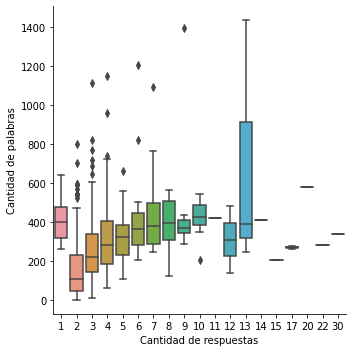

In [18]:
sns.catplot(x="Cantidad de respuestas", y="Cantidad de palabras", kind="box", data=df)

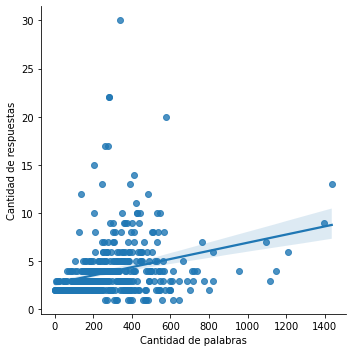

In [19]:
sns.lmplot(x="Cantidad de palabras", y="Cantidad de respuestas", data=df);

Analizando la relación entre la cantidad de palabras y cantidad de respuestas, podemos observar que realizar preguntas de más de 600 palabras no lograría que se incremente la cantidad de respuestas. En el rango entre 200 y 600 palabras es donde se observa la mayor cantidad de respuestas, esto podría suceder debido a que las preguntas más extensas podrían tener requerimientos más específicos o podrían ser más engorrosas de leer, generando que obtengan menos respuestas.  